# ALERT Doctoral School 2023

## Hands-on regression methods - Exercise 1


Author: Filippo Masi

### Objectives
- Learn how to perform regression to obtain an interpretable (hyper-elastic) constitutive model that best fits stress-strain ($\tau-\gamma$) data;

#### Disclaimer

This hands-on notebook is devoted to **Regression methods** and it covers chapter 2.<br>
In the following, the code cells introduced by a tag **[TODO]** are meant to be completed by you!

### 1. Introduction

We start by importing the libraries and functions needed for the exercise.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(6)

colorb=(0.2,0.4,0.7)
colorr=(0.9,0.1,0.1)

In [2]:
def scaling(x,fit=False,transform=False,inverse_transform=False,norm=True,param=None):
    
    ''' scale variable x
        :param x: variable
        :type x:  umpy array
        :param fit: find scaling parameters
        :type fit:  bool
        :param transform: scale x
        :type transform:  bool
        :param inverse_transform: inverse scale x
        :type inverse_transform:  bool
        :param norm: inverse scale x
        :type norm:  bool
        :param fit: scaling parameters
        :type fit:  list
    
        :return: scaling parameters (if fit=False)
                 :rtype: list 
                 scaled x (if transform=True)
                 :rtype: numpy array 
                 inverse scaled x (if inverse_transform=True)
                 :rtype: numpy array
    '''
    
    if fit==True:
        if norm==True:
            min_ = np.amin(x); max_ = np.amax(x)
            a = 0.5*(max_-min_)
            b = 0.5*(max_+min_)
        else:
            a = np.std(x,axis=0)
            b = np.mean(x,axis=0)
        return [a,b]
    elif transform==True:
        return np.divide(x-param[1],param[0])
    elif inverse_transform==True:
        return np.multiply(x,param[0])+param[1]

***Problem:*** Find the constitutive model that best fits the data (imported below) using regression methods.

To do so, we continue by importing the data set.

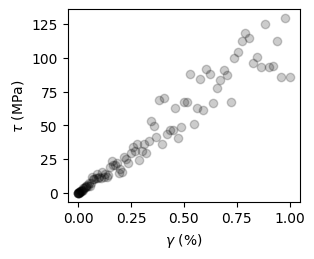

In [3]:
import pickle
file = './data/MAT1'
with open(file, 'rb') as f_obj:
    X,y = pickle.load(f_obj) # X = strain, y = stress
    
# plot
fig = plt.figure(figsize=(3., 2.5))
plt.plot(X*100,y/1e6,'ko',alpha=0.2)
plt.ylabel('$\\tau$ (MPa)')
plt.xlabel('$\gamma$ (%)')
plt.show()

Now, we proceed by splitting the data set into a training and test set, using Scikit-Learn's train_test_split.

Then, we scale both independent ($\gamma$) and dependent ($\tau$) variables based on the statistics of the training data set.

**Remember:** Given a feature $x$, its scaled counterpart $\bar{x}$ reads

$
\bar{x} = \dfrac{1}{\alpha}\left(x-\beta\right),
$

where $\alpha \equiv \frac{1}{2}\left(\max(x) - \min(x)\right)$ and $\beta\equiv\alpha+\min(x)$ for normalization ($\pm$ 1) and $\alpha \equiv \sigma (x)$ and $\beta\equiv \mu (x)$, with $\mu$ and $\sigma$ being the mean and standard deviation, respectively, for standardization ($\mu(\bar{x})=0$, $\sigma(\bar{x})=1$).


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) # split into training and test sets

param_x = scaling(X_train,fit=True) # scaling params for independent variable X
param_y = scaling(y_train,fit=True) # scaling params for dependent variable y

# Scale independent variables (training and test sets)
norm_X_train = scaling(X_train,transform=True,param=param_x) 
norm_X_test = scaling(X_test,transform=True,param=param_x) 

# Scale dependent variables (training and test sets)
norm_y_train = scaling(y_train,transform=True,param=param_y)
norm_y_test = scaling(y_test,transform=True,param=param_y)

At this point, we need to construct the polynomial basis functions using Scikit-Learn's PolynomialFeatures (we will consider up to the sixth degree). Once we have the basis functions, we can proceed with a linear regression.

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 

poly_features = PolynomialFeatures(degree=6, include_bias=False)
norm_X_poly = poly_features.fit_transform(norm_X_train) # augment X data set with polynomial features up to degree=degree 
lin_reg = LinearRegression() 
lin_reg.fit(norm_X_poly,norm_y_train) # perform linear regression
lin_reg.intercept_, lin_reg.coef_

(0.03596609312933774,
 array([ 1.1670445 ,  0.25768115, -0.07775421, -0.47973272, -0.3668392 ,
        -0.09082236]))

The above linear regression model finds the following best-fit equation

$\bar{\tau} = 0.036 + 1.167 \bar{\gamma} + 0.257 \bar{\gamma}^2 -0.077 \bar{\gamma}^3 -0.479 \bar{\gamma}^4 -0.367 \bar{\gamma}^5 -0.091 \bar{\gamma}^6.
$

We can now deploy it to make predictions and compare the latter with the test set

In [6]:
# Make new predictions
x = np.expand_dims(np.linspace(0,0.01,200),1)
norm_x = scaling(x,transform=True,param=param_x)
norm_x_poly = poly_features.fit_transform(norm_x)
norm_y_predicted = lin_reg.predict(norm_x_poly)
y_predicted = scaling(norm_y_predicted,inverse_transform=True,param=param_y)

We can now compare the predictions with the test data set

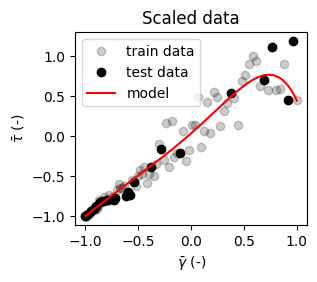

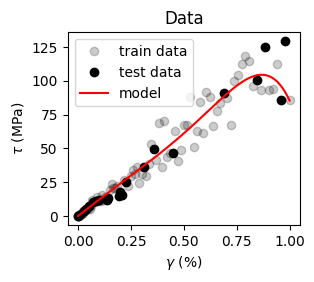

In [7]:
fig = plt.figure(figsize=(3., 2.5))
plt.title('Scaled data')
plt.plot(norm_X_train,norm_y_train,'ko',alpha=0.2,label='train data')
plt.plot(norm_X_test,norm_y_test,'ko',label='test data')
plt.plot(norm_x,norm_y_predicted,'r-',label='model')
plt.ylabel('$\\bar{\\tau}$ (-)')
plt.xlabel('$\\bar{\gamma}$ (-)')
plt.legend()
plt.show()


fig = plt.figure(figsize=(3., 2.5))
plt.title('Data')
plt.plot(X_train*100,y_train/1e6,'ko',alpha=0.2,label='train data')
plt.plot(X_test*100,y_test/1e6,'ko',label='test data')
plt.plot(x*100,y_predicted/1e6,'r-',label='model')
plt.ylabel('$\\tau$ (MPa)')
plt.xlabel('$\gamma$ (%)')
plt.legend()
plt.show()

**[TODO-1]**
- Is the above polynomial model satisfactory?

*Hint:* Check the predictions of the model for larger deformations (extrapolation).

**[TODO-2]**
- Can you find a more accurate (yet interpretable) constitutive model? [Find the expression: $\bar{\tau}= \bar{\tau}(\bar{\gamma})$]

*Hint*: Yes, you can: refer to all different regression models/methods we have seen so far.

**[TODO-3]**
- Once you have found the model that best fits the data, compute the expression of the effective stiffness $G$.

*Note*: The effective stiffness $G$ is defined as 

$G \equiv \dfrac{d \tau}{d \gamma}(\gamma).
$

*N.B.* Pay attention to features scaling!